In [ ]:
# package loading
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

In [ ]:
# Data generation
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]

X = np.r_[X1, X2]
y = np.r_[y1, y2]

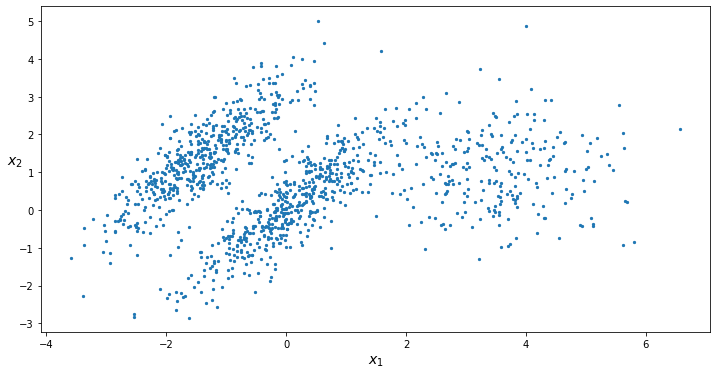

In [ ]:
# visualize the data
def plot_clusters(X, y=None):
    
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap='autumn')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

In [ ]:
# GMM train
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [ ]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

In [ ]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
    else:
        plt.tick_params(labelleft=False)

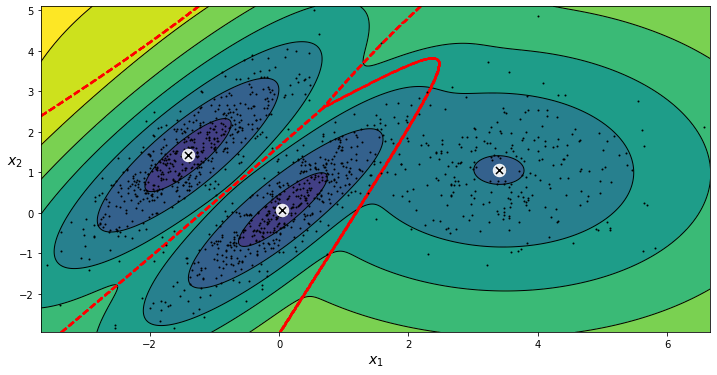

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))

plot_gaussian_mixture(gm, X)

plt.show()

# Selecting the Optimal Number of Clusters

Bayesian information criterion (BIC) 혹은 Akaike information criterion (AIC) 값을 기준으로 최적의 모델 탐색이 가능함.

BIC, AIC: penalized-likelihood criteria
- AIC is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model. So, a lower AIC means a model is considered to be closer to the truth. 
- BIC is an estimate of a function of the posterior probability of a model being true, under a certain Bayesian setup. So, a lower BIC means that a model is considered to be more likely to be the true model. 

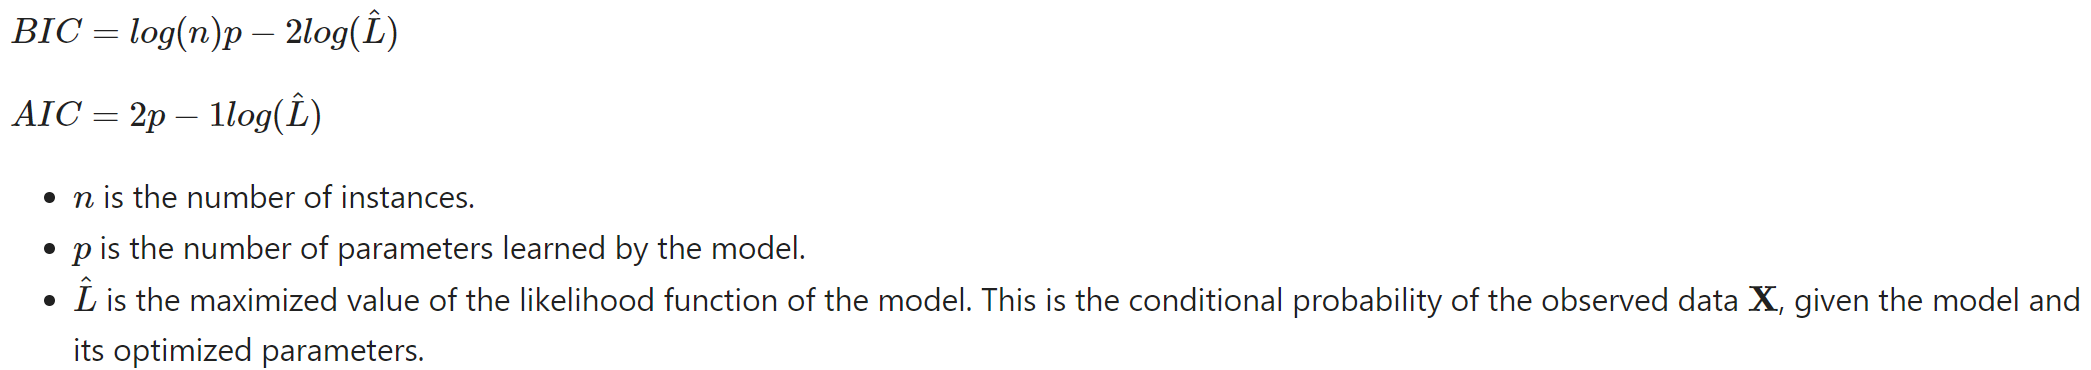

-------
* AIC, BIC 최소화의 의미: 우도(likelihood)를 가장 크게 하는 동시에, 변수 갯수는 가장 적은 최적의 모델을 선택하는 것

* BIC의 경우, 변수가 많을수록 AIC보다 패널티를 크게 가하는 특성이 있음

* BIC가 AIC 보다 변수 증가에 더 민감하기 때문에, 변수 갯수가 적은 것이 우선적으로 고려되어야 한다면 BIC를 기준으로 삼는 것이 좋음

In [ ]:
n_clusters = 3
n_dims = 2

n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2

n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
print(n_params)

17


In [ ]:
# "ccore" method computes the per-sample average log-likelihood of the given data X
max_log_likelihood = gm.score(X) * len(X) # log(L^)
max_log_likelihood

-4034.260860191074

In [ ]:
# BIC and AIC copmutation
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

print("BIC: ", bic)
print("AIC: ", aic)

BIC:  8189.747000497186
AIC:  8102.521720382148


In [ ]:
# Train GMM with various values of k
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [ ]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

In [ ]:
print("BIC:")
print(bics)
print("AIC:")
print(aics)

BIC:
[9330.418496222055, 8971.197133122107, 8189.747000497186, 8229.595643711533, 8273.785246729552, 8311.996155416307, 8350.89457398886, 8391.038436209936, 8432.267971405674, 8465.222274137555]
AIC:
[9304.764002070573, 8914.757245988847, 8102.521720382148, 8111.584970614717, 8124.989180650959, 8132.414696355936, 8140.52772194671, 8149.886191186008, 8160.3303333999675, 8162.499243150071]


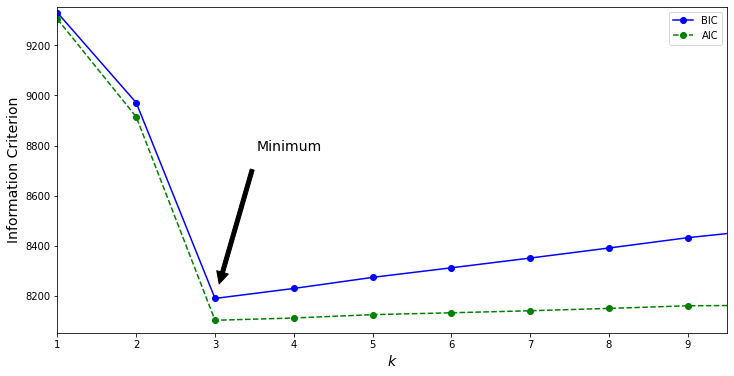

In [ ]:
# visualize the BICs and AICs
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]), # 화살이 가리키는 위치
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1) # shrink: 텍스트로부터 얼마나 떨어진 위치에서 화살표가 시작하는가? (0-1 사이)
            )
plt.legend()
plt.show()

# Model selection by finding optimal k and covariance type

In [ ]:
# optimal k is 3 (above)
# best combination of values for both the number of clusters and the covariance_type hyperparameter

min_bic = np.infty # 무한대의 상수

for k in range(1, 11):
    
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
    
print("\nOptimal k: ", best_k)
print("\nOptimal Covariance Type: ", best_covariance_type)


Optimal k:  3

Optimal Covariance Type:  full
